In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
image_file = "data/8.JPG"
img = cv2.imread(image_file)

In [3]:
img.shape

(895, 1463, 3)

In [4]:
#https://stackoverflow.com/questions/28816046/
#displaying-different-images-with-actual-size-in-matplotlib-subplot
def display(im_path):
    dpi = 80
    im_data = im_path

    height, width  = im_data.shape[:2]
    
    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Display the image.
    ax.imshow(im_data, cmap='gray')

    plt.show()

In [5]:
# display(image_file)

In [6]:
## Preprocessing:
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
thresh = 175
binary_image = cv2.threshold(gray_img, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

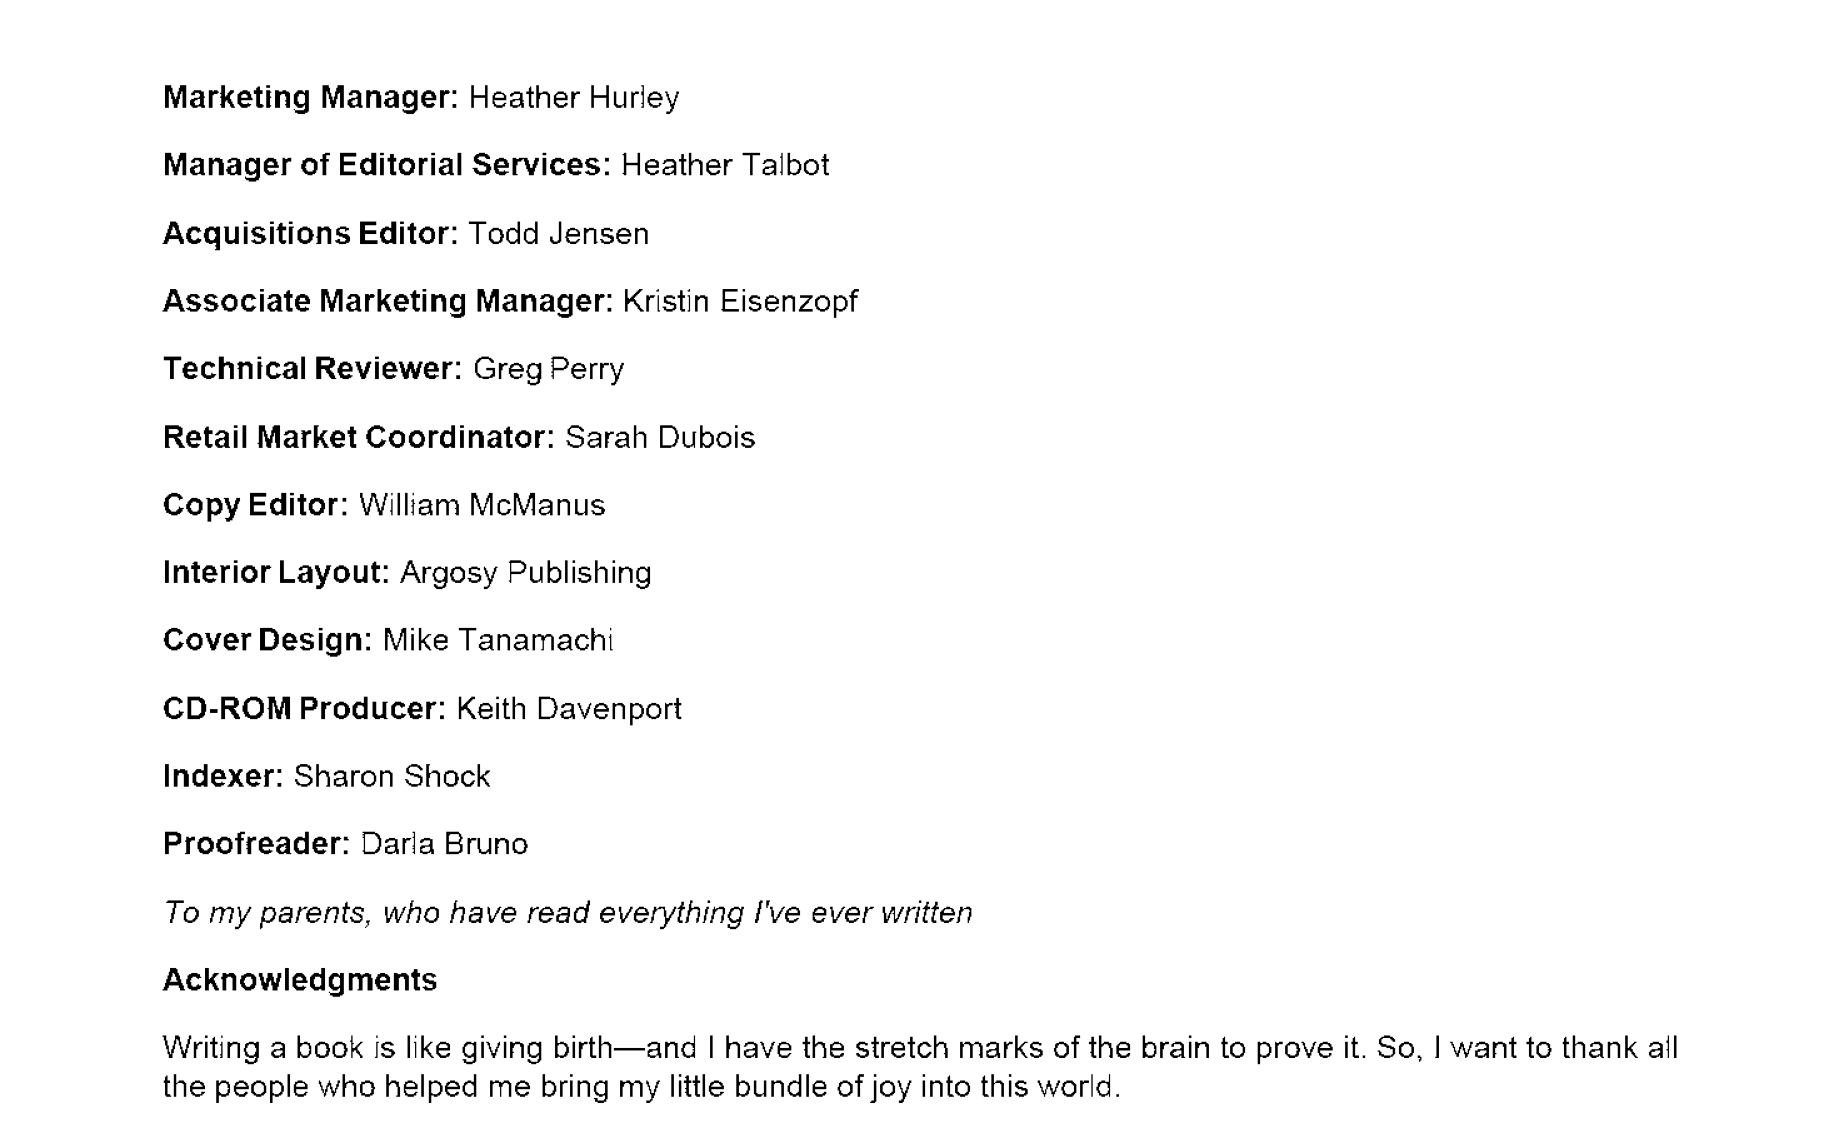

In [7]:
display(binary_image)

In [8]:
import cv2


def preProcessing(myImage):
    grayImg = cv2.cvtColor(myImage, cv2.COLOR_BGR2GRAY)
    ret, thresh1 = cv2.threshold(grayImg, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    print(f'The threshold valua applied to the image is: {ret} ')
    horizontal_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (18, 18))
    dilation = cv2.dilate(thresh1, horizontal_kernel, iterations=1)
    horizontal_contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    im2 = myImage.copy()
    for cnt in horizontal_contours:
        x, y, w, h = cv2.boundingRect(cnt)
        rect = cv2.rectangle(im2, (x, y), (x + w, y + h), (255, 255, 255), 0)
    im2, vertical_contours = seg_word(rect)
    return im2, vertical_contours


def seg_word(wordImage):
    grayImg = cv2.cvtColor(wordImage, cv2.COLOR_BGR2GRAY)
    ret, thresh2 = cv2.threshold(grayImg, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)
    # create a Structuring Element size of 8*10 for the vertical contouring
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (8, 10))
    # apply Dilation for once only
    dilation = cv2.dilate(thresh2, vertical_kernel, iterations=1)
    #fingd the vertical contours
    vertical_contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    word_img = wordImage.copy()
    # Run through each contour and extract the bounding box
    for cnt in vertical_contours:
        #computes the minimum rectangle
        x, y, w, h = cv2.boundingRect(cnt)
        # Draw a rectangular from the top left to the bottom right with the
        # given Coordinates x,y and height and width
        rect = cv2.rectangle(word_img, (x, y), (x + w, y + h), (0, 255, 0), 0)
    # apply a Character Segmentation and return the output Image

    return word_img, vertical_contours

The threshold valua applied to the image is: 142.0 


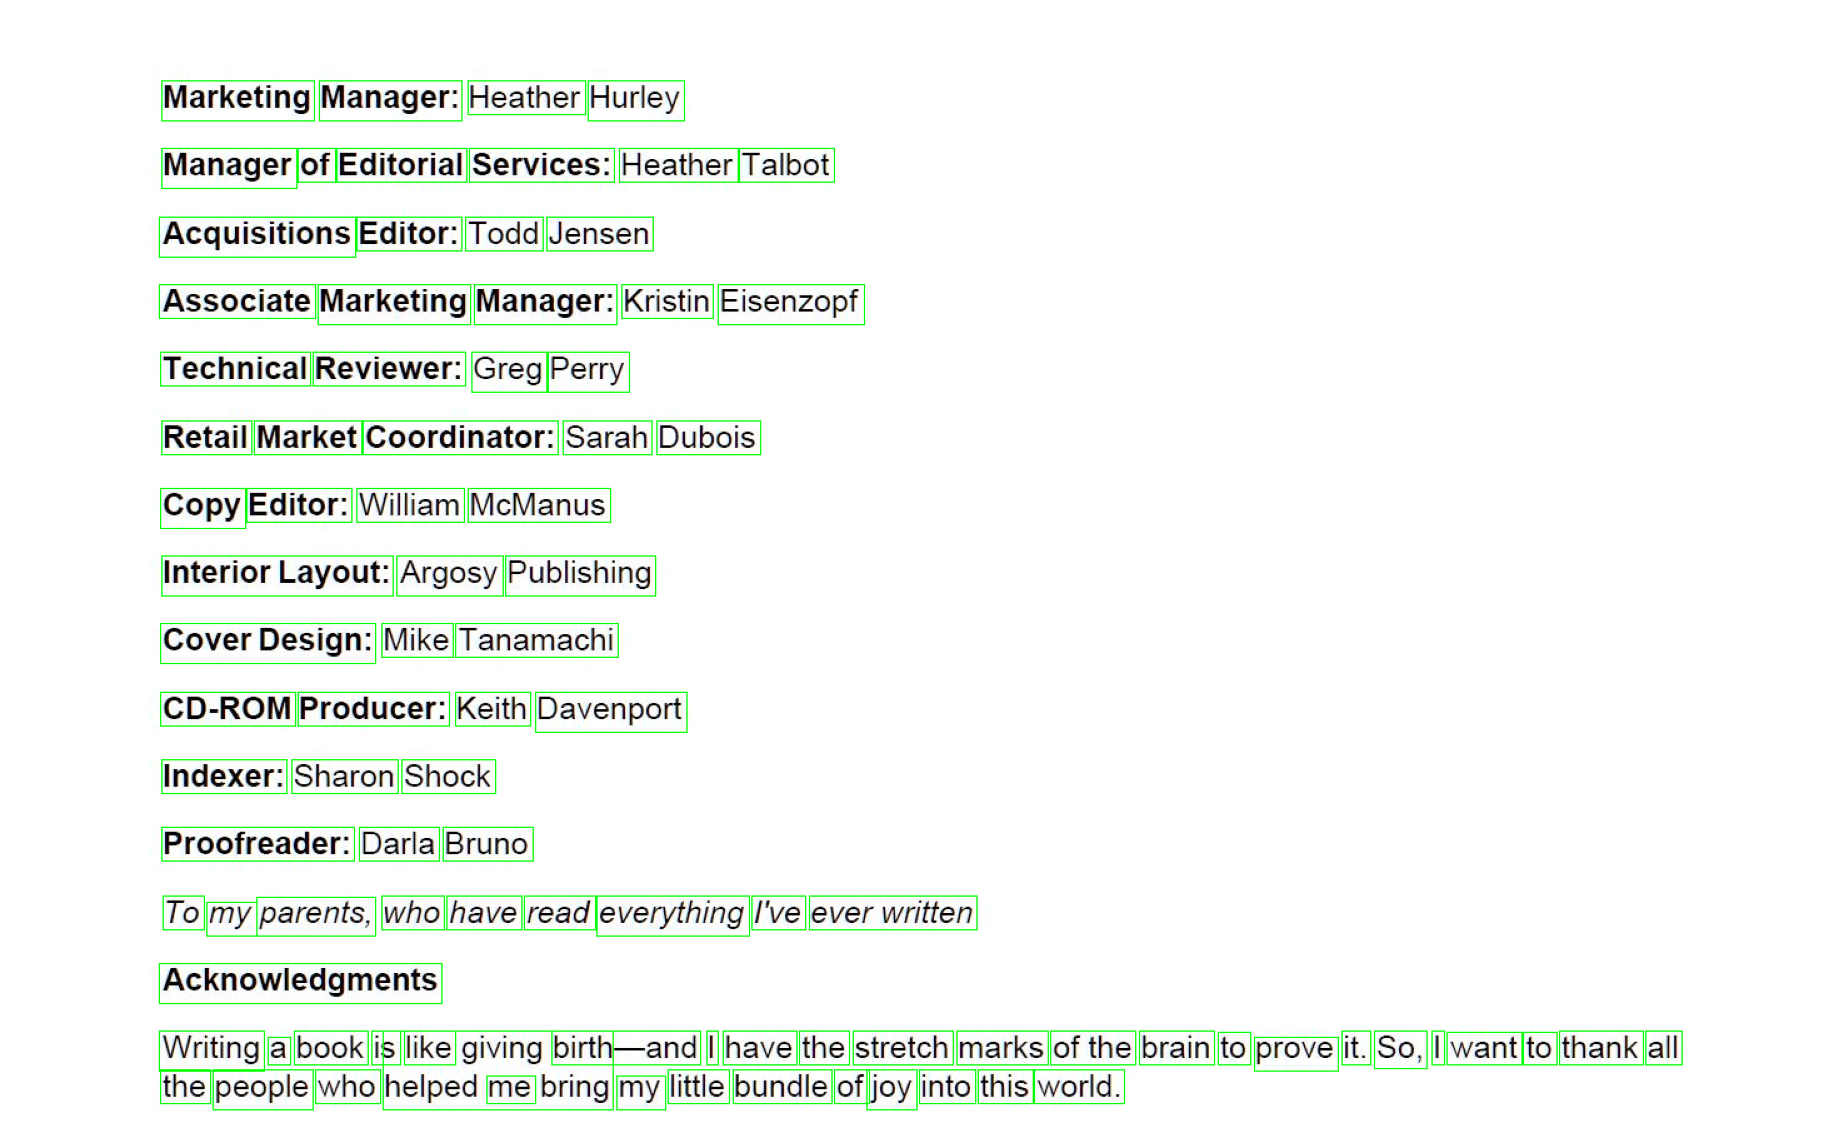

In [9]:
## segmentation
image = cv2.imread(image_file)
im2, vertical_contours = preProcessing(image)

display(im2)

In [71]:
bbox = []
for cnt in vertical_contours:
        #computes the minimum rectangle
        x, y, w, h = cv2.boundingRect(cnt)
        
        bbox.append([x,y,w,h])

In [72]:
bbox = sorted(bbox, key = lambda x: (x[0], x[1]) )

## Italics detection

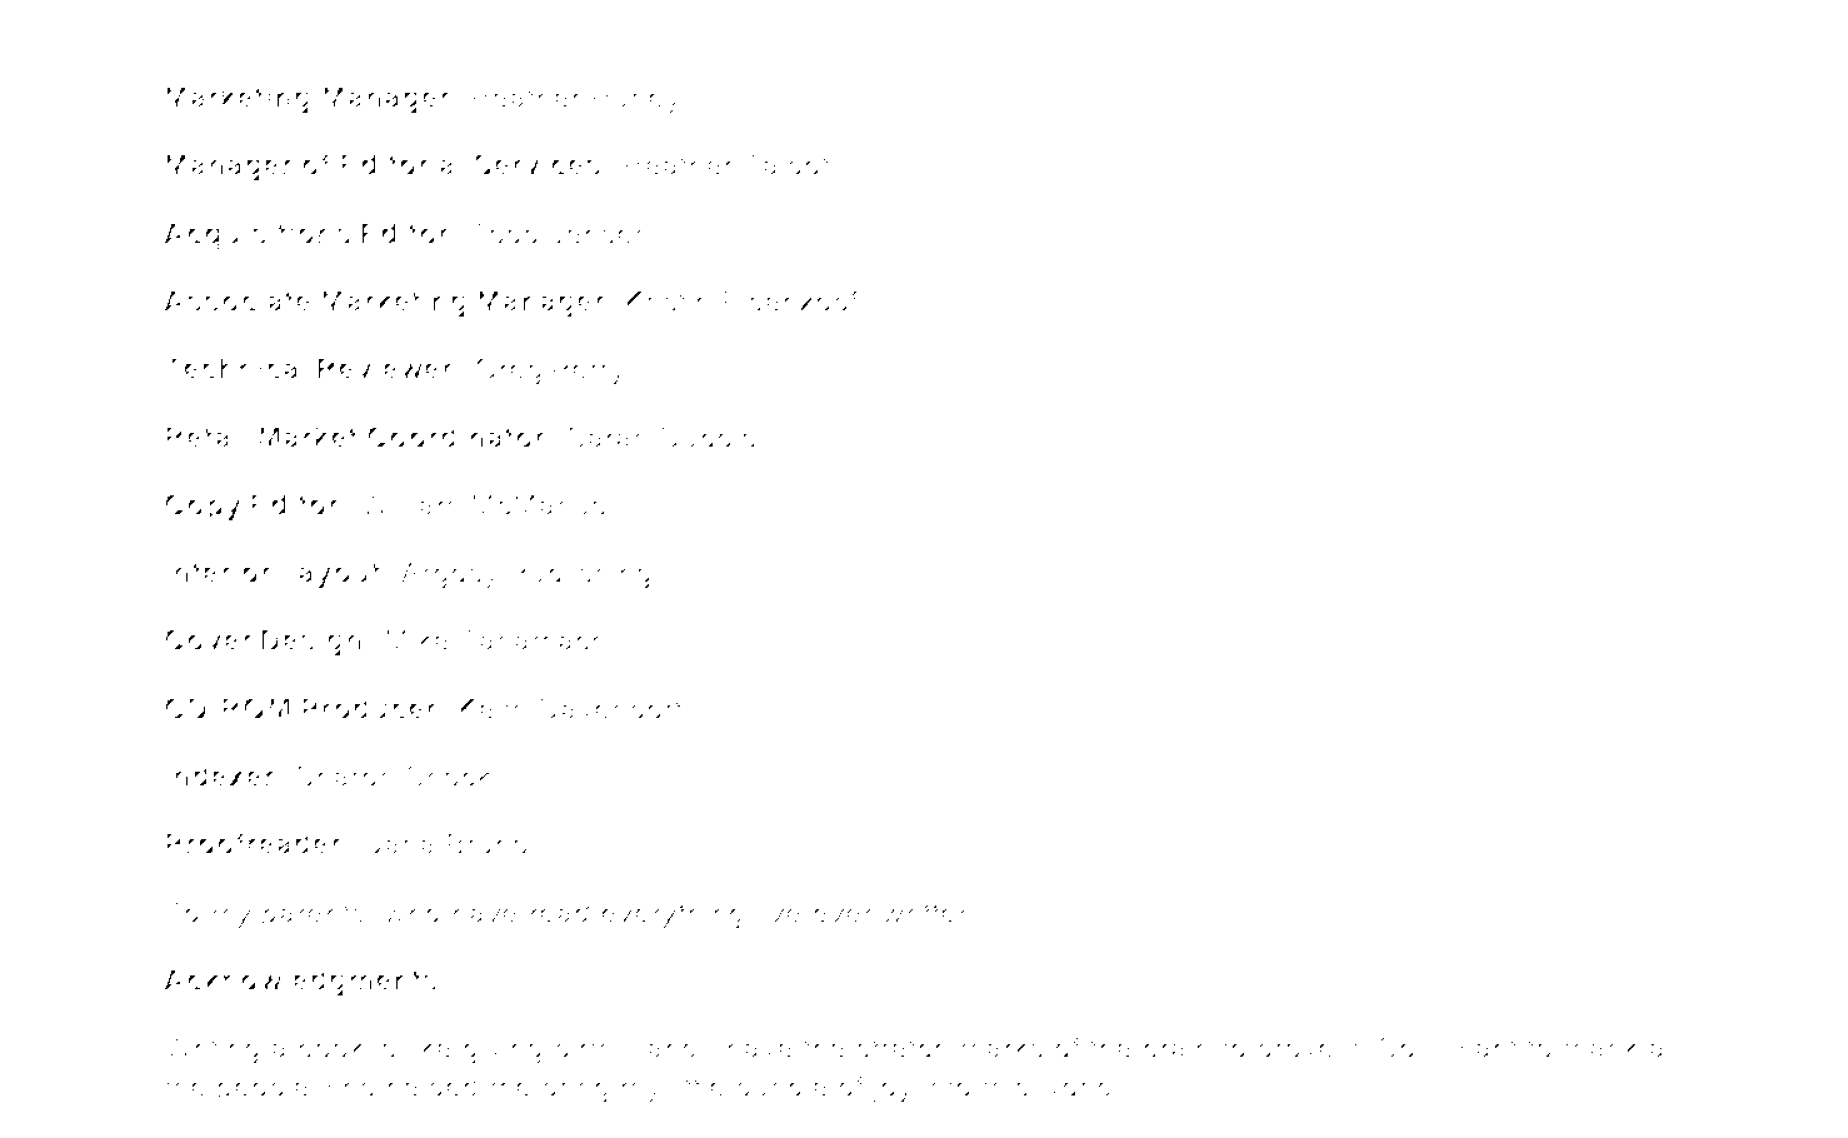

5312

In [17]:
KERNEL_ITALIC = np.asarray([
    [0,0,0,1],
    [0,0,1,0],
    [0,1,0,0],
    [1,0,0,0],
], np.uint8)

filtered_image_x= cv2.filter2D(binary_image, -1, KERNEL_ITALIC)
display(filtered_image_x)
np.sum(filtered_image_x == 0)

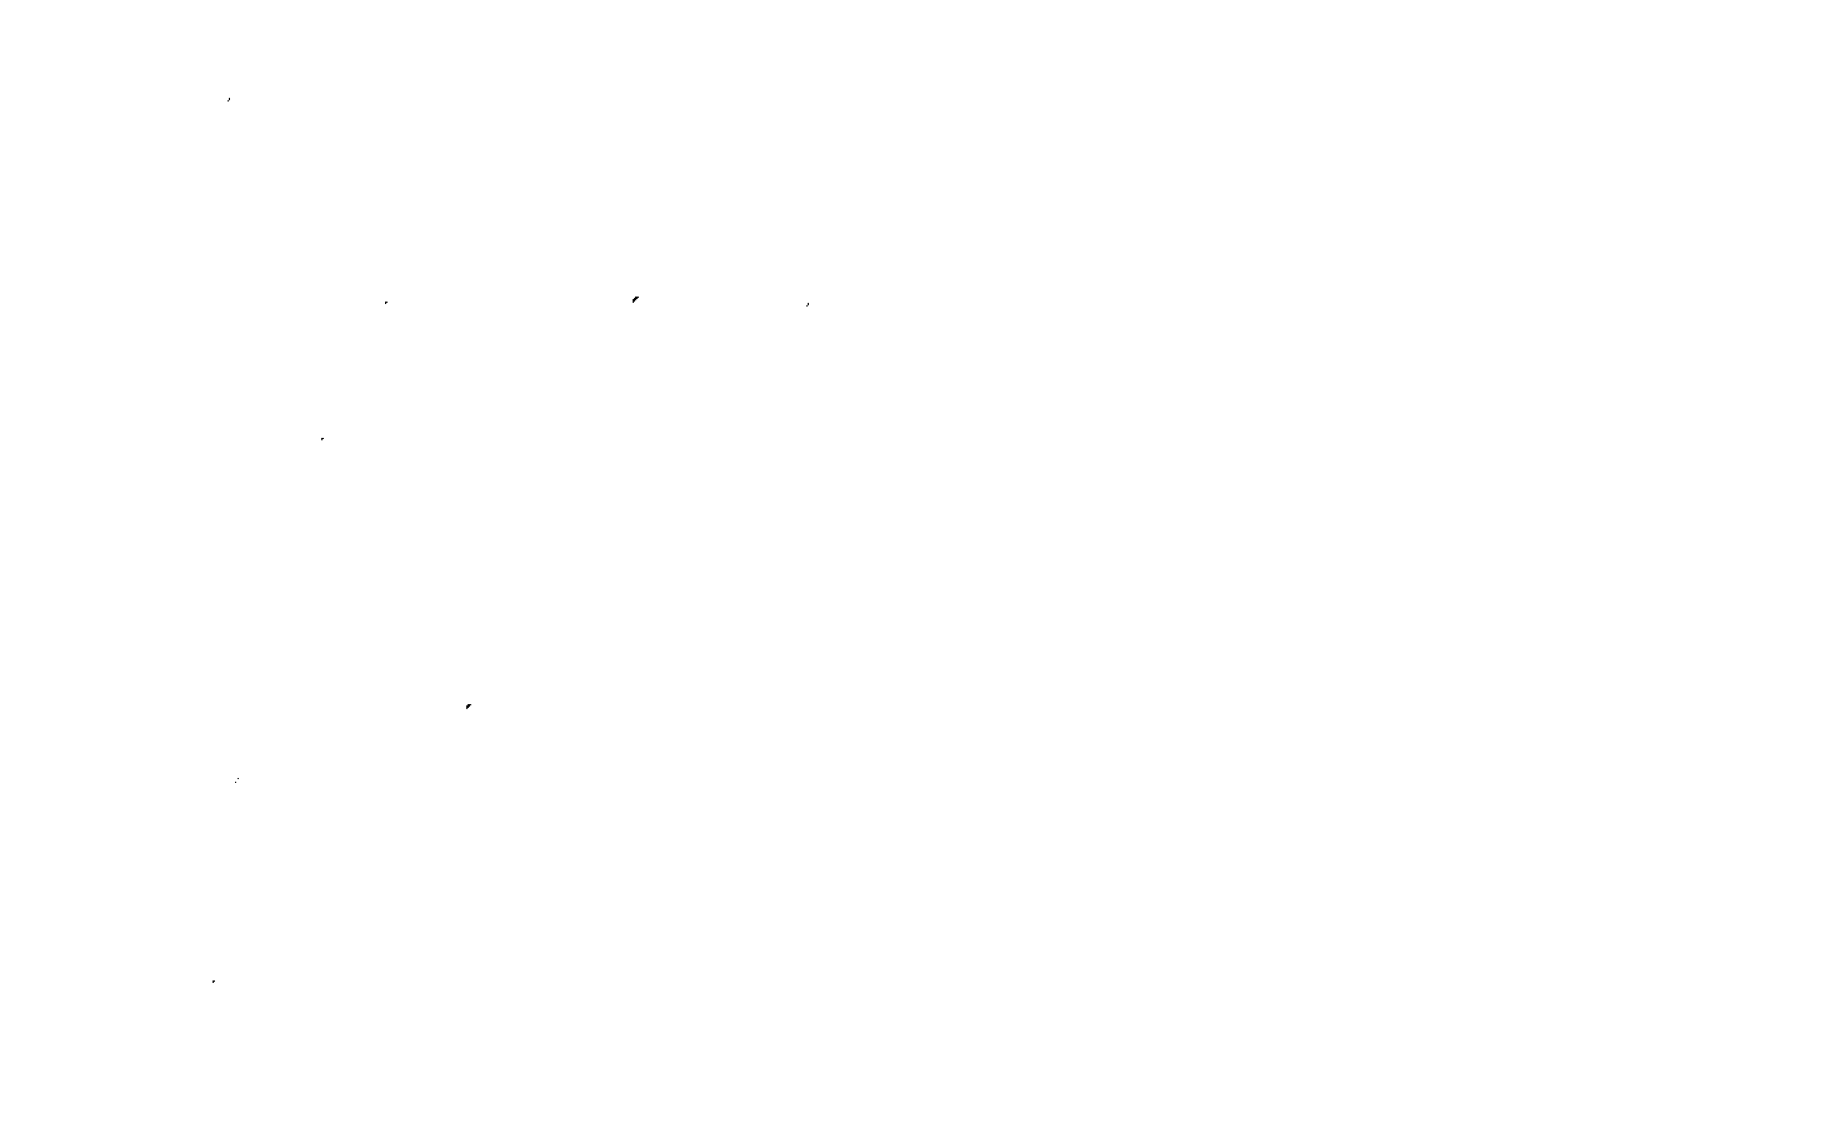

38

In [19]:
filtered_image_x= cv2.filter2D(filtered_image_x, -1, KERNEL_ITALIC)
display(filtered_image_x)
np.sum(filtered_image_x == 0)

In [73]:
# https://stackoverflow.com/questions/67577793/detecting-bold-and-italic-text-in-an-image
KERNEL = np.asarray([
    [1, 1, 1, 1],
    [1, 1, 1, 1],
    [1, 1, 1, 1],
], np.uint8)
KERNEL_ITALIC = np.asarray([
    [0, 0,0,1, 1, 1],
    [0, 0,0,1, 1, 1],
    [0, 0,0,1, 1, 1],
    [0, 0,1, 1, 1, 0],
    [0, 0,1, 1, 1, 0],
    [0, 0,1, 1, 1, 0],
    [1, 1, 1,0,0, 0],
    [1, 1, 1,0,0, 0],
    [1, 1, 1,0,0, 0],
], np.uint8)

def pre_process_italic(img):
    img_f = cv2.flip(img, 1)
    img = cv2.bitwise_not(img)
    img = cv2.erode(img, KERNEL_ITALIC, iterations=1)
    img = cv2.dilate(img, KERNEL, iterations=1)

    img_f = cv2.erode(img_f, KERNEL_ITALIC, iterations=1)
    img_f = cv2.dilate(img_f, KERNEL, iterations=1)
    img_f = cv2.flip(img_f, 1)
    img = cv2.bitwise_not(img)
    return img, img_f

In [74]:
def apply_func_italics(vertical_contours, image, p_img):
    ratio = []
    for cnt in vertical_contours:
        x,y,w,h = cv2.boundingRect(cnt)
        word1 = image[y:y+h, x:x+w]
        word2 = p_img[y:y+h, x:x+w]
        a,b = np.sum(word1 == 0), np.sum(word2 == 0)
        

        ratio.append(get_ratio(a,b))
    return ratio

def get_ratio(a, b):
    return ((a - b) / (a + b + 1e-8)) * 2

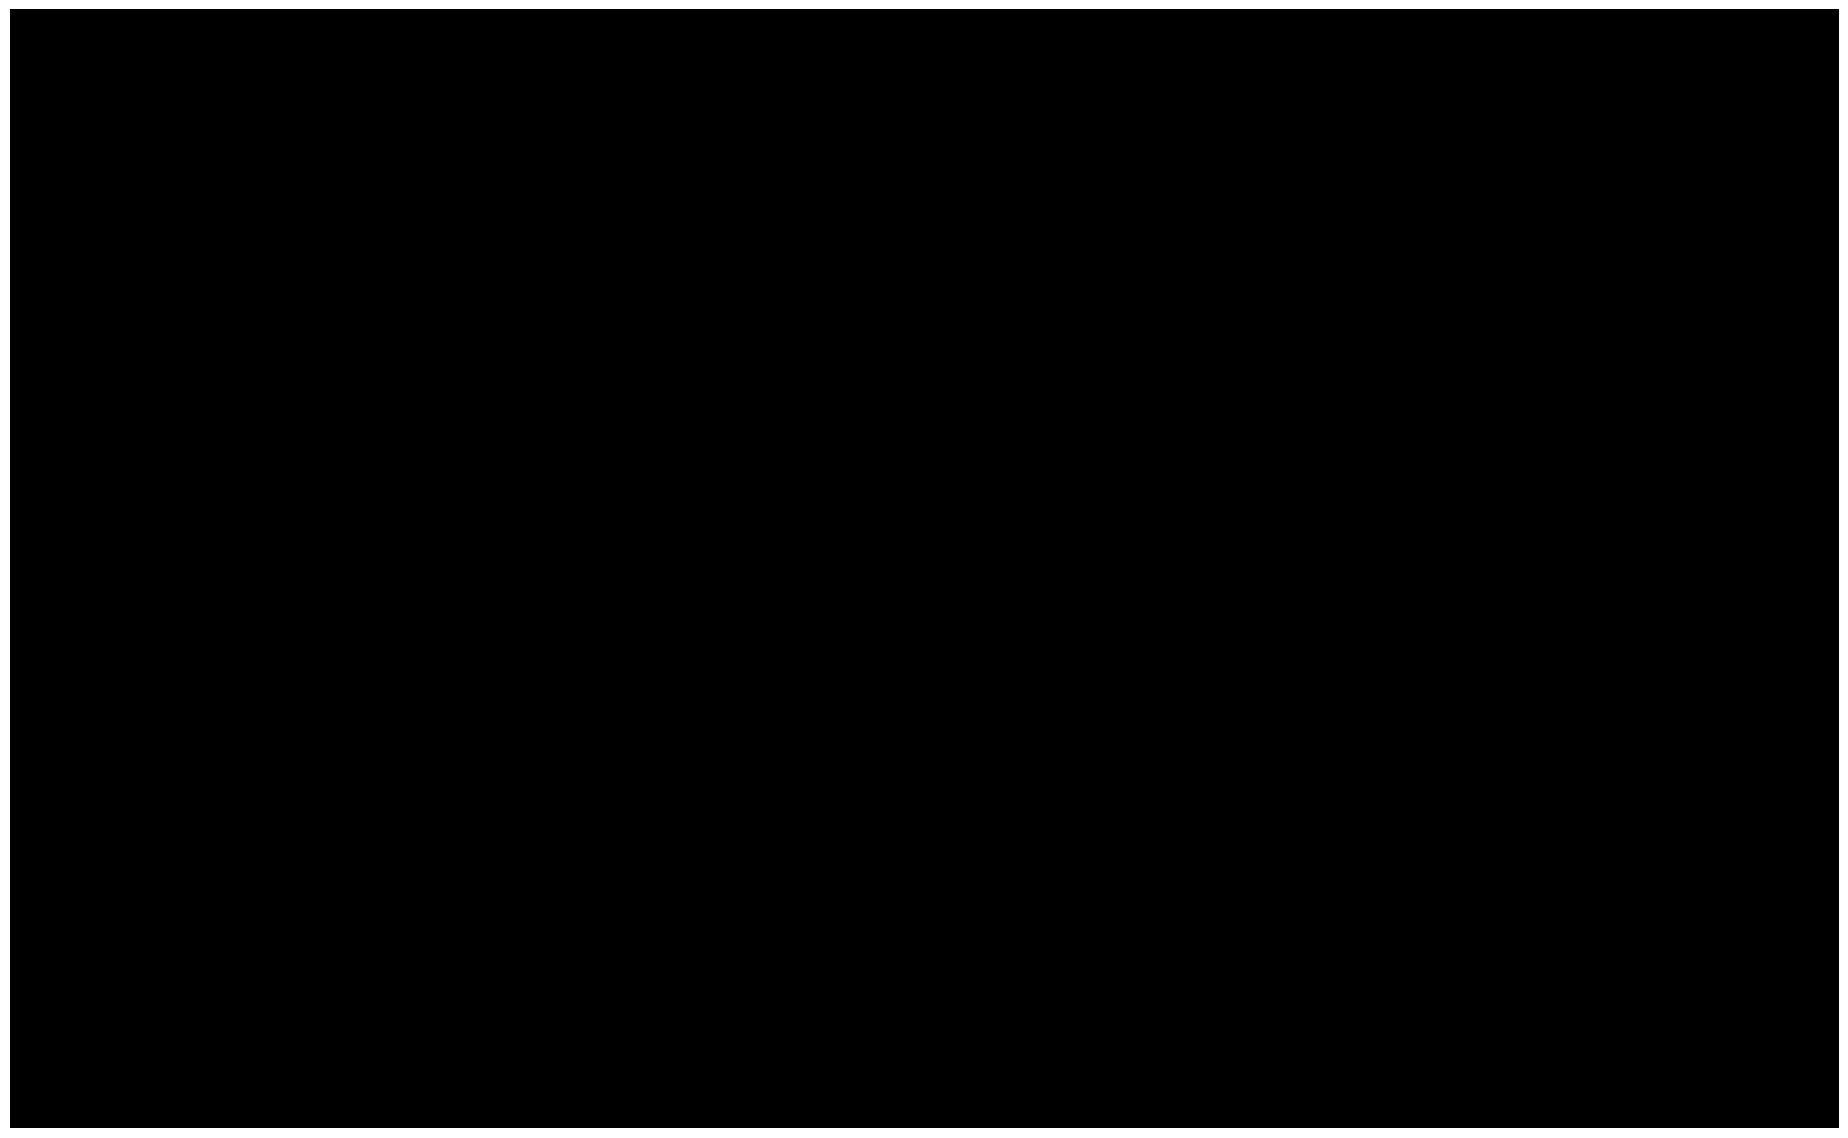

In [75]:
img, img_f = pre_process_italic(binary_image)
ratio = apply_func_italics(vertical_contours, img, img_f)
# display(img)
# print(ratio)

for i in range(2):
    img , img_f = pre_process_italic(img)

display(img)

In [62]:
# import numpy as np

# def generate_italic_kernel(kernel_size):
#     # Create an empty kernel
#     kernel = np.zeros((kernel_size, kernel_size), dtype=np.uint8)

#     # Fill the kernel to emphasize left-leaning edges
#     for i in range(kernel_size):
#         for j in range(kernel_size):
#             if j <= i:
#                 kernel[i, j] = 1

#     return kernel

# # Example usage:
# kernel_size = 5  # Adjust the kernel size as needed
# italic_kernel = generate_italic_kernel(kernel_size)
# print("Italic Kernel:")
# print(italic_kernel)

Italic Kernel:
[[1 0 0 0 0]
 [1 1 0 0 0]
 [1 1 1 0 0]
 [1 1 1 1 0]
 [1 1 1 1 1]]
